# **GARCH and EGarch Models**

## **0.0 Imports**

In [102]:
import pandas as pd
import yfinance as yf
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

### **0.1 Load Data**

In [45]:
#Get data
ticker = yf.Ticker("USDBRL=X")


#Into df
start = '2002-01-01'
end = '2021-10-01'

df_usd = ticker.history(start=start, end = end, interval = "1d").reset_index()

#Get only close data
cols = ['Date', 'Close']
df_usd = df_usd[cols].set_index('Date')

### **0.2. Helper Function**

In [70]:

##pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [13, 6]
    plt.rcParams['font.size'] = 20
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### **0.3 Data Visualization**

Text(0.5, 0, 'Data')

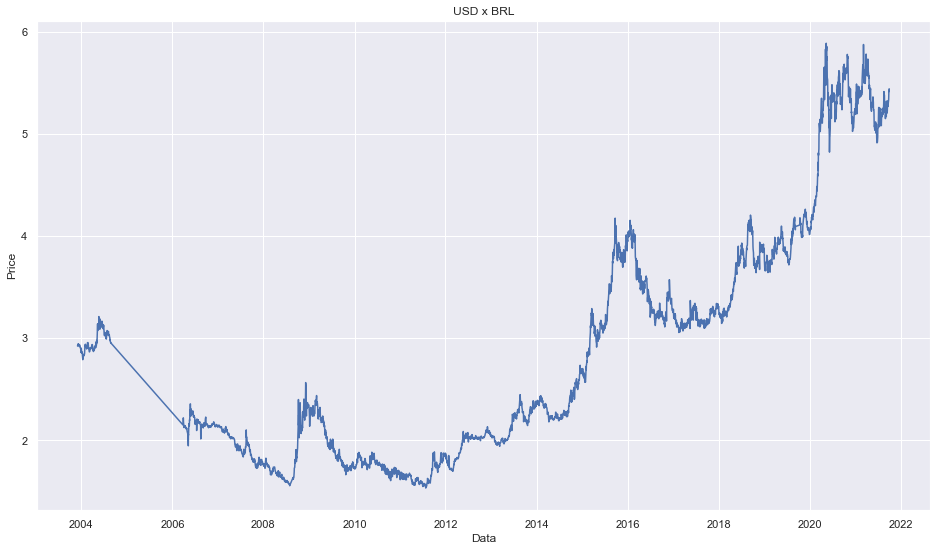

In [59]:
sns.lineplot(x = 'Date', y = 'Close', data = df_usd)
plt.title('USD x BRL')
plt.ylabel('Price')
plt.xlabel('Data')

### **0.4 Check NA**

In [51]:
df_usd.isna().sum()

Close    0
dtype: int64

# **1.0 Non-Normality Distribution of Fat Tails**    

### *The Jacque Bera is a test of whether sample data have the skewness and kurtosis matching a normal distriubtion.*

In [56]:
#Test
jarque_bera = scipy.stats.jarque_bera(df_usd['Close'])

#Test Statistic
jarque_bera.statistic

#P value
jarque_bera.pvalue


0.0

# **2.0 Serial Correlation and Unit Root**

## **2.1 PACF and ACF tests**

c:\Users\victo\Music\Projetos\volatility\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


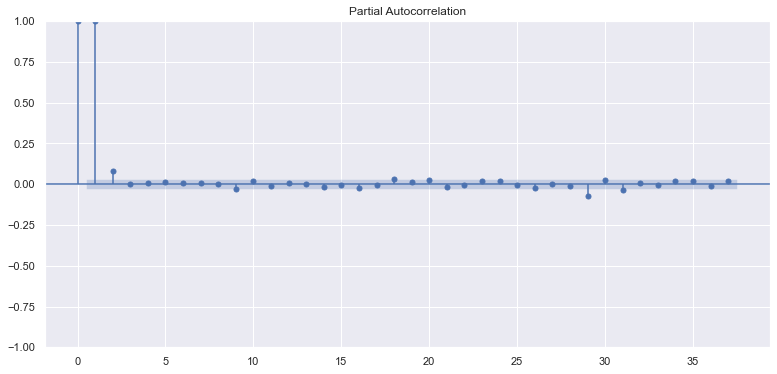

In [71]:
plot_pacf(df_usd['Close'])
plt.show()

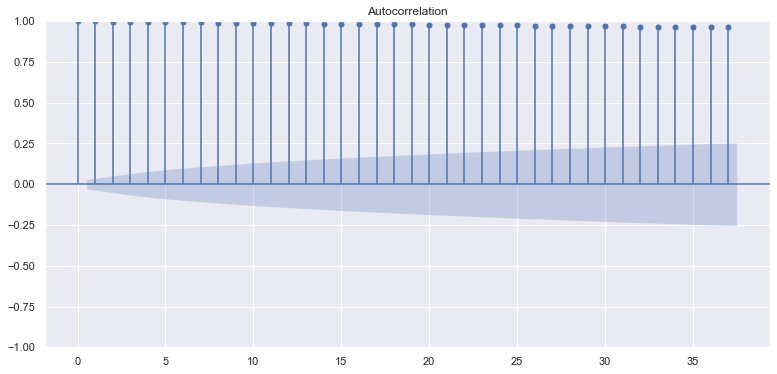

In [72]:
plot_acf(df_usd['Close'])
plt.show()

## **2.1 Stationary Tests**

### **2.1.1 Test without any differences - ADF test > -2.862 (5%): Non-stationary serie**

In [91]:
result = adfuller(df_usd['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.277019
p-value: 0.976265
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.2 Test with one differences - ADF Test < -2.862 (5%). We have a stationary serie**

In [98]:
#Get first diff
df2 = df_usd.copy().diff()

#Dropping NA values
df2.dropna(inplace = True)

In [101]:
result_diff = adfuller(df2['Close'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.631831
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.3 Test without any differences - KPSS > 0.463 (5%). Non Stationary serie**

In [114]:
result_kpss = kpss(df_usd['Close'])
print('ADF Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 7.444846
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


c:\Users\victo\Music\Projetos\volatility\venv\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### **2.1.3 Test with one differences - KPSS <> 0.463 (5%).  Stationary serie**

In [115]:
result_diff_kpss = kpss(df2['Close'])
print('ADF Statistic: %f' % result_diff_kpss[0])
print('p-value: %f' % result_diff_kpss[1])
print('Critical Values:')
for key, value in result_diff_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.460329
p-value: 0.051151
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


# **3.0 Parametric Volatility Models**

## **3.1. The ARCH Model**